## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [1]:
from cgitb import reset
!pip3 install tqdm -q

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

ModuleNotFoundError: No module named 'metric_tests'

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре. 

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [ ]:
lol = pd.read_csv('interactions.csv').iloc[:-1]

lol['last_watch_dt'].min(), lol['last_watch_dt'].max()

('2021-03-13', '2021-08-22')

In [200]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [201]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(10)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
1130002,383743,15297,93,16831,63.0
1937067,570281,8896,52,7516,100.0
347553,996341,2557,106,15819,33.0
460046,861639,2657,116,8065,11.0
3742436,418965,10497,151,11689,50.0
5387626,608753,4471,113,7135,100.0
4184898,319233,142,106,78,2.0
496658,160465,4231,161,5223,80.0
2249968,965606,6447,154,862,17.0
24328,663329,8171,83,6679,98.0


Сделаем разбиение по времени

<Axes: >

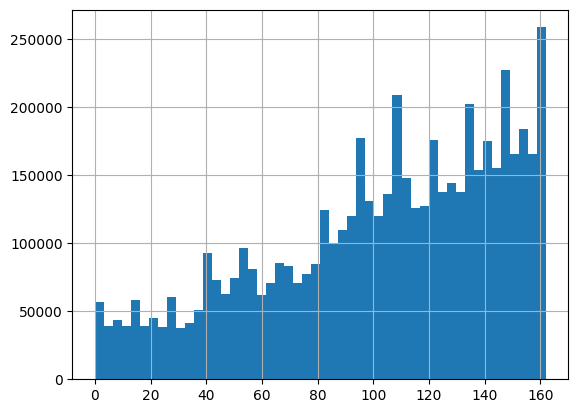

In [202]:
df.last_watch_dt.hist(bins=50)

In [203]:
train_df = df.loc[(df.last_watch_dt < 160 - 7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160 - 7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [204]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [205]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [206]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,59,4250,72.0
49,474544,10440,95,36469,90.0
85,910002,11143,151,710,10.0
95,858651,15998,110,63,9.0
112,490158,817,139,930,16.0


In [207]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0: 'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0: 'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

/var/folders/c7/pltxzd0965307j_5v2_v9brh0000gn/T/ipykernel_41708/2892034827.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
/var/folders/c7/pltxzd0965307j_5v2_v9brh0000gn/T/ipykernel_41708/2892034827.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,165,"[(12173, 122)]"
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399..."
3,446,"[(13865, 105)]"
4,515,"[(3734, 114), (9728, 114), (4457, 115), (13865..."


In [208]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,165,"[(12173, 122)]","[(4969, 161)]"
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]"
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]"
4,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,..."


In [209]:
np.random.seed(777)


class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)] * len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,165,"[(12173, 122)]","[(4969, 161)]","[11705, 9045, 8487]"
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633...","[11705, 9045, 8487]"
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[11705, 9045, 8487]"
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[11705, 9045, 8487]"
4,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[11705, 9045, 8487]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$.

In [210]:
def ap_metric(
        gt_items: List[int],
        predictions: List[int],
        topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)

    denominator = min(topn, len(gt_items))

    if denominator == 0:
        denominator = 1

    left = 1 / denominator

    r = np.isin(predictions[:topn], gt_items).astype(int)

    p_i = np.cumsum(r) / (np.arange(len(r)) + 1)

    result = left * np.sum(r * p_i)

    return result


def rr_metric(
        gt_items: List[int],
        predictions: List[int],
        topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)

    r = np.isin(predictions[:topn], gt_items).astype(int)

    relevant_items = np.where(r == 1)

    if len(relevant_items) == 0 or len(relevant_items[0]) == 0:
        return 0

    return 1 / (relevant_items[0][0] + 1)


def hr_metric(
        gt_items: List[int],
        predictions: List[int],
        topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)

    r = np.isin(predictions[:topn], gt_items).astype(int)

    return int(np.any(r == 1))


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит. 

In [211]:
run_tests(ap_metric, rr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать. 

In [212]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):
    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

In [357]:
def evaluate_recommender_topk(df, predictions, top_k, gt_col='test_interactions'):
    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        preds = predictions[idx]

        ap = ap_metric(gt_items, preds, top_k)
        rr = rr_metric(gt_items, preds, top_k)
        hr = hr_metric(gt_items, preds, top_k)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [213]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': np.float64(1.6666666666666664e-05),
 'mrr': np.float64(5e-05),
 'hr': np.float64(0.0001)}

In [214]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10) -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,165,"[(12173, 122)]","[(4969, 161)]","[11705, 9045, 8487]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633...","[11705, 9045, 8487]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[11705, 9045, 8487]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[11705, 9045, 8487]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[11705, 9045, 8487]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [215]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': np.float64(0.0690354226505417),
 'mrr': np.float64(0.12128011904761904),
 'hr': np.float64(0.3053)}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [216]:
class TopPopularWeighted(TopPopular):

    def __init__(self, max_dt=0, min_window=2):
        super().__init__()
        self.min_window = min_window
        self.max_dt = max_dt

    def fit(self, df, col='train_interactions', time_window=30):
        counts = {}
        time_threshold = self.max_dt - time_window

        if time_threshold < 0:
            time_threshold = 1

        for _, row in df.iterrows():
            for item, dt in row[col]:
                if dt >= time_threshold:
                    if item in counts:
                        counts[item] += 1
                    else:
                        counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10) -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]] * len(df)

# your code here

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна.

In [217]:
max_dt = df.last_watch_dt.max()

for window in range(5, 66, 10):
    topPopW = TopPopularWeighted(max_dt=max_dt, min_window=5)

    topPopW.fit(joined, time_window=window)

    col_name = 'toppW_recs@' + str(window)

    joined[col_name] = topPopW.predict(joined)

    print()
    print(col_name)
    print(evaluate_recommender(joined, model_preds=col_name))


toppW_recs@5
{'map': np.float64(0.0), 'mrr': np.float64(0.0), 'hr': np.float64(0.0)}

toppW_recs@15
{'map': np.float64(0.07027613430650037), 'mrr': np.float64(0.12453253968253969), 'hr': np.float64(0.3179)}

toppW_recs@25
{'map': np.float64(0.07184886378810784), 'mrr': np.float64(0.13058019841269838), 'hr': np.float64(0.3179)}

toppW_recs@35
{'map': np.float64(0.07166839728206098), 'mrr': np.float64(0.13062218253968252), 'hr': np.float64(0.3171)}

toppW_recs@45
{'map': np.float64(0.07311016931216932), 'mrr': np.float64(0.13303488095238097), 'hr': np.float64(0.3148)}

toppW_recs@55
{'map': np.float64(0.0731479549004787), 'mrr': np.float64(0.12966575396825397), 'hr': np.float64(0.3036)}

toppW_recs@65
{'map': np.float64(0.07215884290753338), 'mrr': np.float64(0.1313626984126984), 'hr': np.float64(0.3045)}


Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:**
 При маленьком окне  качество рекомендаций нулевое, так как скорее всего такого маленького промежутка времени не хватает для определения наиболее популярных элементов.

При среднем окне  качество рек-ий значительно улучшилось, так большее окно позволяет учитывать большее кол-во элементов и точнее определить наиболее популярные.

При бОльшем окне качество рек-ий начинает ухудшаться, так как скорее всего начинают учитываться устаревшие айтемы.

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике. 

In [218]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

In [219]:
map = []
mrr = []
hr = []

k_val = range(1, 101, 1)

for k in k_val:
    joined['toppopular_recs'] = toppop.predict(joined, topn=k)
    metrics = evaluate_recommender(joined, 'toppopular_recs')

    map.append(metrics['map'])
    mrr.append(metrics['mrr'])
    hr.append(metrics['hr'])

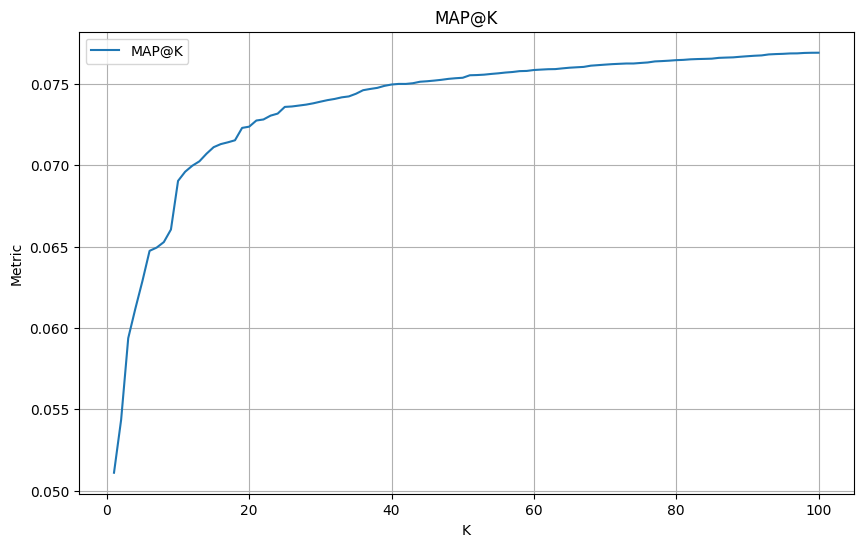

In [220]:
plt.figure(figsize=(10, 6))
plt.plot(k_val, map, label='MAP@K', linestyle='-')

plt.xlabel("K")
plt.ylabel("Metric")
plt.title("MAP@K")
plt.legend()
plt.grid()
plt.show()

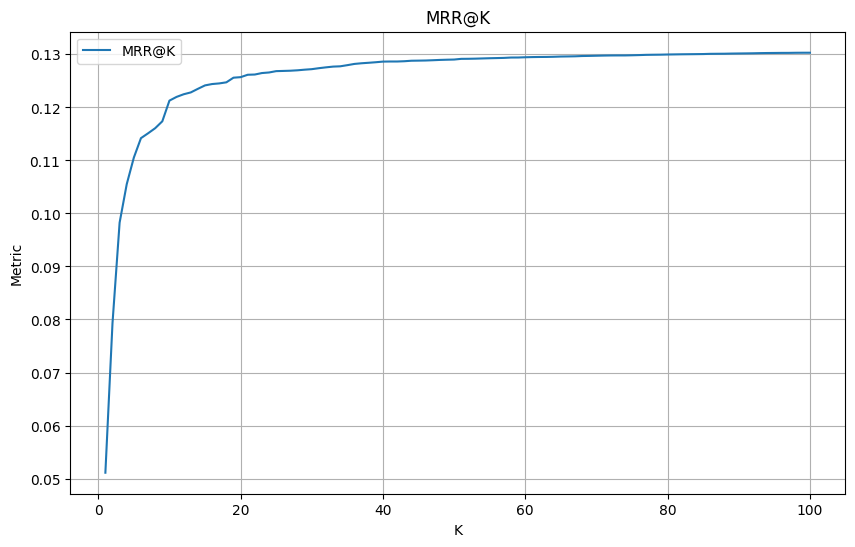

In [221]:
plt.figure(figsize=(10, 6))
plt.plot(k_val, mrr, label='MRR@K', linestyle='-')

plt.xlabel("K")
plt.ylabel("Metric")
plt.title("MRR@K")
plt.legend()
plt.grid()
plt.show()

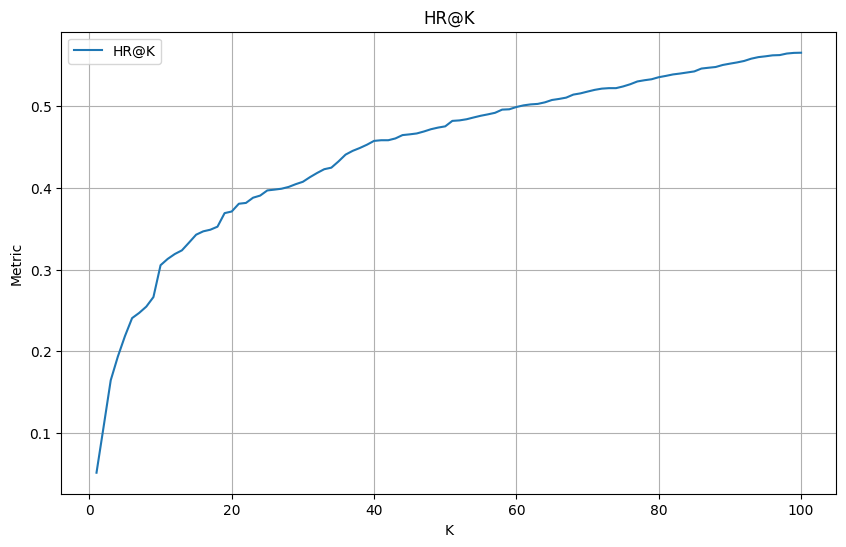

In [222]:
plt.figure(figsize=(10, 6))
plt.plot(k_val, hr, label='HR@K', linestyle='-')

plt.xlabel("K")
plt.ylabel("Metric")
plt.title("HR@K")
plt.legend()
plt.grid()
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:**
Все три графика являются монотонными.

- HR@K: Чем больше  𝐾, тем больше элементов охватывается, увеличивая вероятность попадания хотя бы одного релевантного элемента.
- MRR@K: Если релевантный элемент уже найден на меньших  𝐾, увеличение K не ухудшает значение, а может только улучшить его.
- MAP@K: Метрика аккумулирует точность и может улучшаться, но стабилизируется, когда релевантные элементы исчерпываются.

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:**

- MAP@K: Если пользователь скроллит до конца списка рекомендаций, MAP указывает на то, насколько высоко релевантные элементы расположены в этом списке. Чем выше MAP, тем больше релевантных элементов в верхних позициях рекомендаций.
- MRR@K: Эта метрика важна для сценариев, где пользователь ожидает быстрый результат (например, поиск товара или информации). Чем выше MRR, тем раньше пользователь находит релевантный результат.
- HR@K: Важно для сценариев, где пользователю нужно, чтобы хотя бы один релевантный элемент оказался в ленте. Например, в новостных лентах или рекомендательных системах.

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**

MAP и MRR:
Они растут медленно, так как при увеличении K добавляются нерелевантные элементы, что снижает точность. Релевантные элементы в конце списка делают меньший вклад в метрику, особенно для MAP.

HR:
растет быстрее, чем другие метрики, потому что она не зависит от точного порядка релевантных элементов в списке, а только от их наличия.

Поведение объясняется тем, как метрики устроены. MAP и MRR зависят от порядка и точности рекомендаций, а HR учитывает только факт наличия релевантного элемента.

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей.

In [223]:
items = pd.read_csv('items.csv')[['item_id', 'title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

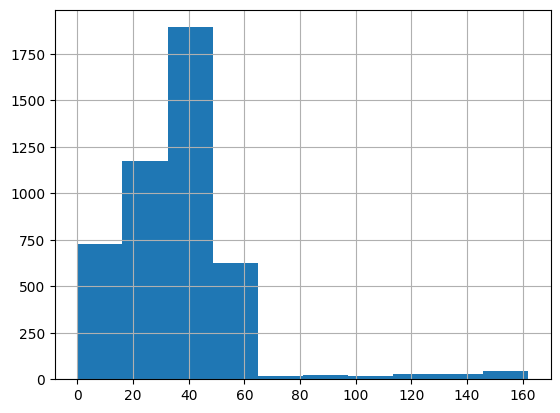

In [224]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id == sampled_id].copy()
name = items.loc[items.item_id == sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной. 

Добавьте 5 своих примеров ниже. Опишите, как вы их искали.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


def analyze_movie_popularity(interactions, items):
    temp_df = interactions.merge(items, on='item_id', how='left')

    temp_df['last_watch_dt'] = pd.to_datetime(temp_df['last_watch_dt'], unit='D', origin='2021-03-13')
    temp_df['count'] = 1

    time_series = (
        temp_df.groupby(['item_id', pd.Grouper(key='last_watch_dt')])
        .agg({'count': 'sum'})
        .reset_index()
    )

    time_series_pivot = time_series.pivot(index='item_id', columns='last_watch_dt', values='count').fillna(0)

    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(time_series_pivot)

    kmeans = KMeans(n_clusters=10, random_state=42)
    clusters = kmeans.fit_predict(normalized_data)
    time_series_pivot['cluster'] = clusters

    return time_series_pivot

In [180]:
# result = analyze_movie_popularity(df, items)

# print(result['cluster'])

### У нас есть 5 кластеров, у которых разное поведение. Давайте смотреть, что в них происходит.

name: Материнский инстинкт
cluster_id: 0


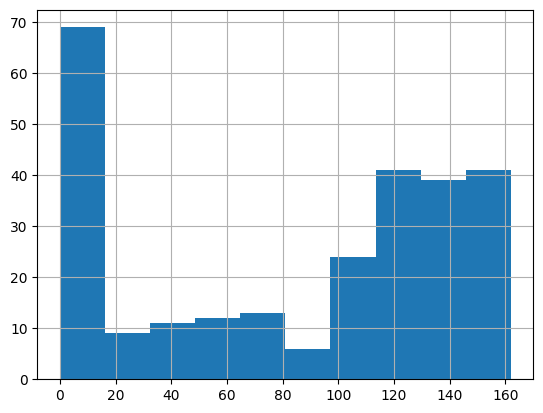

name: Хрустальный
cluster_id: 1


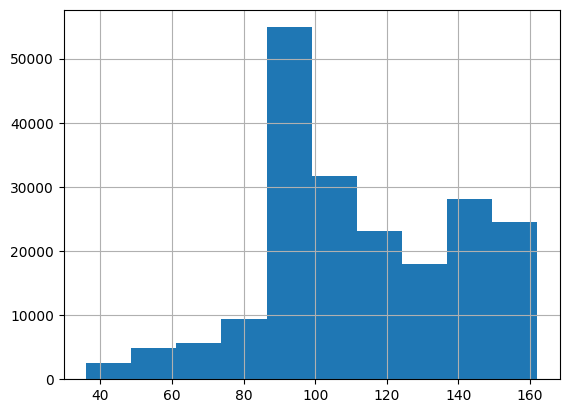

name: Любовь
cluster_id: 2


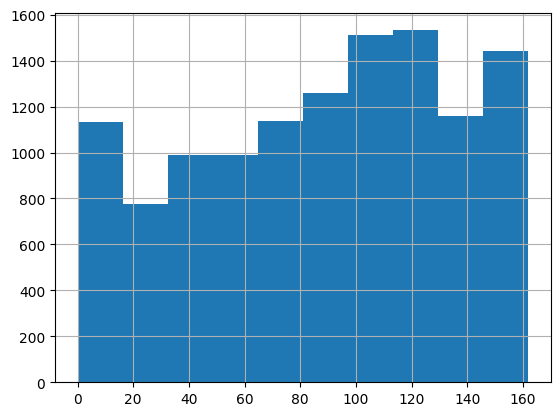

name: Цвет из иных миров
cluster_id: 3


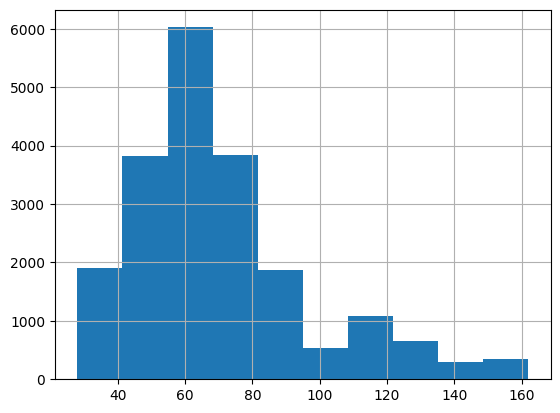

name: Прабабушка легкого поведения
cluster_id: 4


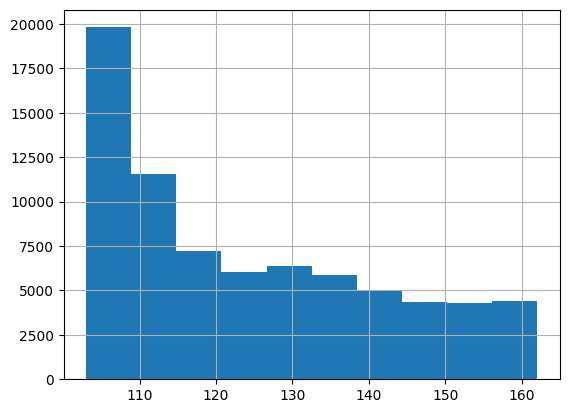

In [182]:
# for cluster_id in range(5):
#     cluster_item = np.random.choice(result[result['cluster'] == cluster_id].index.tolist())
#
#     sampled_id = cluster_item
#
#     interactions = df.loc[df.item_id == sampled_id].copy()
#     name = items.loc[items.item_id == sampled_id].title.values[0]
#     print("name:", name)
#     print("cluster_id:", cluster_id)
#     interactions.last_watch_dt.hist()
#     plt.show()

### Так, мы получили 5 графиков. Давайте попробуем сделать какие-нибудь предположения.
- Насчет первого фильма видно (name: Материнский инстинкт, cluster_id: 0), что он в марте резко набирает популярность. Скорее всего это связано с тем, что на 8 марта смотрят фильмы про матерей
- Насчет второго (name: Хрустальный, cluster_id: 1), Хрустальный - это сериал, который релизнули в 2021. Скорее всего на 80 день пришелся пик его популярности, так как стало понятно, кому он нравится, и релизнулось достаточное кол-во серий
- Любовь (name: Любовь, cluster_id: 2) - это фильм 2015 года. Он стабильно набирает просмотры. Может быть просто хайповал в тиктоке
- Цвет из иных миров (name: Цвет из иных миров, cluster_id: 3) - sci-fi фильм 2019 года. На +- 60 день выпадают майские праздники, мб люди просто массово сели смотреть фильмы, и этот тоже попал под раздачу
- Прабабушка легкого поведения (name: Прабабушка легкого поведения, cluster_id: 4) - фильм 2021 года, видно, что он релизнулся в +- июне, и тут явный паттерн, что было много просмотров сразу после релиза, потом популярность утихла

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках.

In [225]:
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,59,4250,72.0
1,699317,1659,77,8317,100.0
2,656683,7107,57,10,0.0
3,864613,7638,114,14483,100.0
4,964868,9506,48,6725,100.0


In [400]:
def filter_column(df, col, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """

    counts = df[col].value_counts()
    filt_df = df[df[col].isin(counts[counts >= min_freq].index)]

    return filt_df


def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """

    new_df = df.copy()

    while True:
        size = new_df.shape

        for col in cols:
            new_df = filter_column(new_df, col, min_freq)

        if new_df.shape == size:
            break

    return new_df


filtered_train = filter_dataframe(df, ['user_id', 'item_id'])

In [401]:
def df_encode(df):
    item2id = {k: v for v, k in enumerate(df.item_id.unique())}
    user2id = {k: v for v, k in enumerate(df.user_id.unique())}

    id2item = {k: v for v, k in item2id.items()}
    id2user = {k: v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df


filtered_train = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
5228055,89484,3834,123,7288,100.0
903703,232302,328,131,4691,91.0
5050738,4029,5205,126,1654,30.0
2162417,15403,1784,134,83,2.0
4912355,78129,1617,90,4884,94.0


In [402]:
item2id = {k: v for v, k in enumerate(df.item_id.unique())}
user2id = {k: v for v, k in enumerate(df.user_id.unique())}

id2item = {k: v for v, k in item2id.items()}
id2user = {k: v for v, k in user2id.items()}

In [403]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<COOrdinate sparse matrix of dtype 'float64'
	with 4278492 stored elements and shape (962179, 15706)>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра. 

In [236]:
def analyze_interaction_thresholds(df, cols=['user_id', 'item_id'], min_freq_values=range(1, 21)):
    user_counts = []
    item_counts = []

    for min_freq in min_freq_values:
        filtered_df = filter_dataframe(df, cols, min_freq)
        user_counts.append(filtered_df['user_id'].nunique())
        item_counts.append(filtered_df['item_id'].nunique())

    plt.figure(figsize=(10, 6))
    plt.plot(min_freq_values, user_counts, label='users')
    plt.plot(min_freq_values, item_counts, label='items')
    plt.legend()
    plt.grid()
    plt.show()

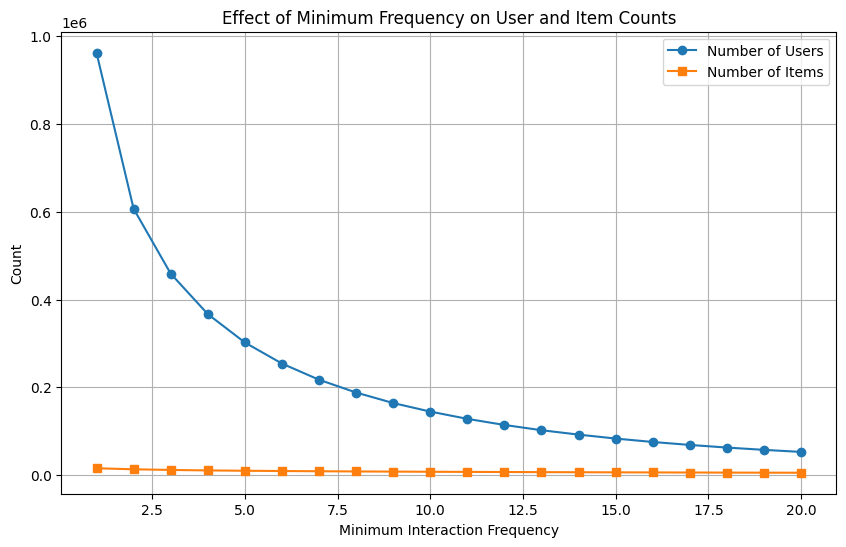

In [238]:
analyze_interaction_thresholds(filtered_train)

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k. 

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [241]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=1000):
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)

    return B


w = fit_ease(matrix)

CPU times: user 12.9 s, sys: 492 ms, total: 13.4 s
Wall time: 7.67 s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [268]:
def get_preds(x, item2id, id2item, w):
    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)
    preds = np.array(vector.dot(w))[0]
    preds[encoded] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:100]

    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppW_recs@5,toppW_recs@15,toppW_recs@25,toppW_recs@35,toppW_recs@45,toppW_recs@55,toppW_recs@65,ease_preds
0,165,"[(12173, 122)]","[(4969, 161)]","[11705, 9045, 8487]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...",[],"[10440, 9728, 15297, 7793, 3734, 12192, 4151, ...","[9728, 10440, 15297, 7793, 3734, 13865, 12192,...","[9728, 10440, 15297, 13865, 3734, 4151, 7829, ...","[9728, 15297, 10440, 13865, 3734, 12192, 4151,...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[9728, 15297, 10440, 3734, 13865, 4151, 12192,...","[0, 6683, 6684, 6685, 6686, 6687, 6688, 6689, ..."
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633...","[11705, 9045, 8487]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...",[],"[10440, 9728, 15297, 7793, 3734, 12192, 4151, ...","[9728, 10440, 15297, 7793, 3734, 13865, 12192,...","[9728, 10440, 15297, 13865, 3734, 4151, 7829, ...","[9728, 15297, 10440, 13865, 3734, 12192, 4151,...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[9728, 15297, 10440, 3734, 13865, 4151, 12192,...","[76, 758, 1850, 1754, 3494, 99, 1898, 196, 60,..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[11705, 9045, 8487]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...",[],"[10440, 9728, 15297, 7793, 3734, 12192, 4151, ...","[9728, 10440, 15297, 7793, 3734, 13865, 12192,...","[9728, 10440, 15297, 13865, 3734, 4151, 7829, ...","[9728, 15297, 10440, 13865, 3734, 12192, 4151,...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[9728, 15297, 10440, 3734, 13865, 4151, 12192,...","[200, 22, 132, 51, 140, 225, 516, 1280, 183, 1..."
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[11705, 9045, 8487]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...",[],"[10440, 9728, 15297, 7793, 3734, 12192, 4151, ...","[9728, 10440, 15297, 7793, 3734, 13865, 12192,...","[9728, 10440, 15297, 13865, 3734, 4151, 7829, ...","[9728, 15297, 10440, 13865, 3734, 12192, 4151,...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[9728, 15297, 10440, 3734, 13865, 4151, 12192,...","[0, 6683, 6684, 6685, 6686, 6687, 6688, 6689, ..."
4,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[11705, 9045, 8487]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...",[],"[10440, 9728, 15297, 7793, 3734, 12192, 4151, ...","[9728, 10440, 15297, 7793, 3734, 13865, 12192,...","[9728, 10440, 15297, 13865, 3734, 4151, 7829, ...","[9728, 15297, 10440, 13865, 3734, 12192, 4151,...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[9728, 15297, 10440, 3734, 13865, 4151, 12192,...","[220, 114, 3981, 1002, 2773, 1455, 60, 1553, 2..."


In [269]:
evaluate_recommender(joined, model_preds='ease_preds')

{'map': np.float64(0.00021695149998323058),
 'mrr': np.float64(0.0005827926955088027),
 'hr': np.float64(0.0135)}

In [270]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': np.float64(0.07691220968575414),
 'mrr': np.float64(0.13031394100404278),
 'hr': np.float64(0.5656)}

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:** Лучше работает TopPopular

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации.

In [ ]:
k = 1
for i in np.logspace(1, 5, num=20):
    print(k)
    k += 1
    w = fit_ease(matrix, reg_weight=i)

    joined['ease_preds@' + str(i)] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [323]:
mape = []
hre = []
mrre = []
i_val = []

for i in np.logspace(1, 5, num=20):
    metrics = evaluate_recommender(joined, 'ease_preds@' + str(i))

    i_val.append(i)
    mape.append(metrics['map'])
    mrre.append(metrics['mrr'])
    hre.append(metrics['hr'])

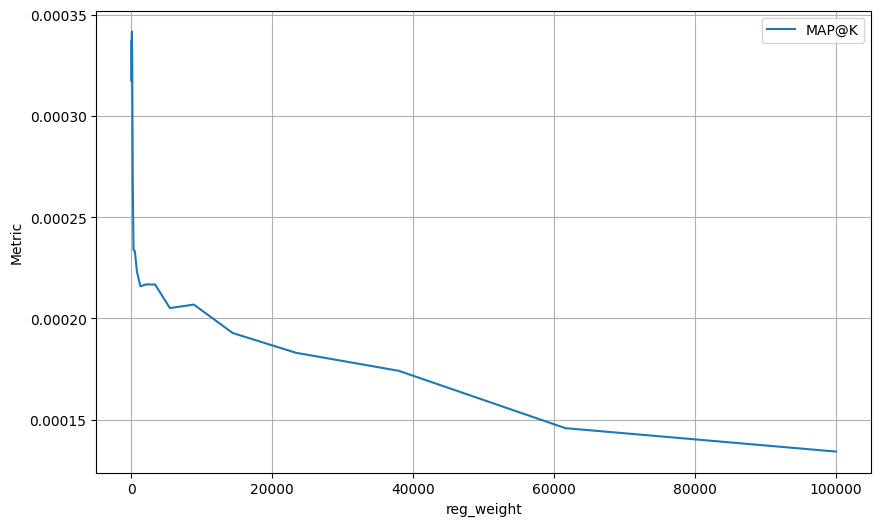

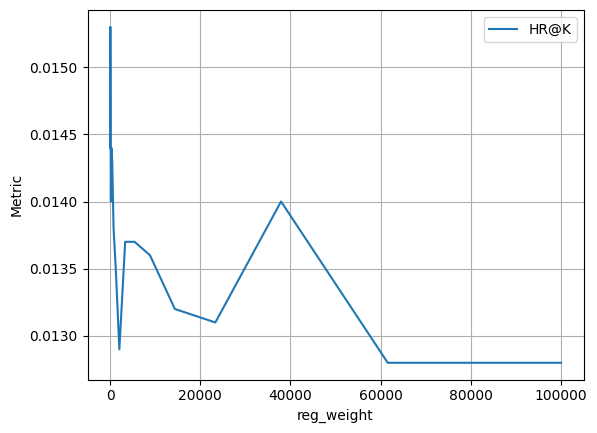

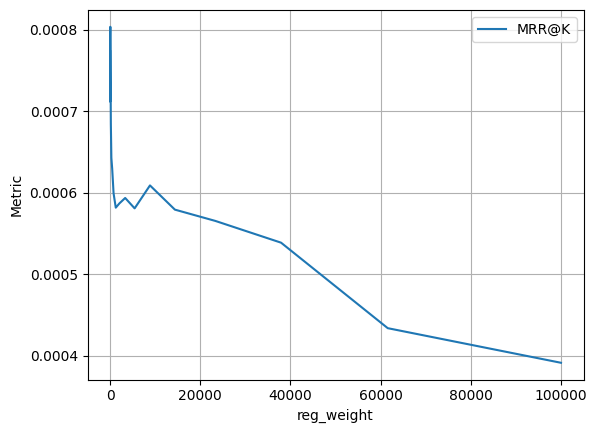

In [325]:
plt.figure(figsize=(10, 6))
plt.plot(i_val, mape, label='MAP@K', linestyle='-')

plt.xlabel("reg_weight")
plt.ylabel("Metric")
plt.legend()
plt.grid()
plt.show()

plt.plot(i_val, hre, label='HR@K', linestyle='-')

plt.xlabel("reg_weight")
plt.ylabel("Metric")
plt.legend()
plt.grid()
plt.show()

plt.plot(i_val, mrre, label='MRR@K', linestyle='-')

plt.xlabel("reg_weight")
plt.ylabel("Metric")
plt.legend()
plt.grid()
plt.show()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим?

**Ответ: Наименьшее**

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:** чем больше параметр регуляризации, тем меньше метрики

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы.

In [358]:
def plot_quality_vs_topk(min_freq_values=range(10, 21, 2), top_k=range(1, 100, 10)):
    results = {metric: {freq: [] for freq in min_freq_values} for metric in ["HR@K", "MAP@K", "MRR@K"]}

    for min_freq in min_freq_values:
        print("min_freq: " + str(min_freq))

        filtered_freq_df = filter_dataframe(df, ['user_id', 'item_id'], min_freq=min_freq)

        filtered_freq_df = df_encode(filtered_freq_df)

        item2id = {k: v for v, k in enumerate(filtered_freq_df.item_id.unique())}
        user2id = {k: v for v, k in enumerate(filtered_freq_df.user_id.unique())}

        id2item = {k: v for v, k in item2id.items()}
        id2user = {k: v for v, k in user2id.items()}

        X = sps.coo_matrix(
            (np.ones(filtered_freq_df.shape[0]), (filtered_freq_df['user_id'], filtered_freq_df['item_id'])),
            shape=(len(user2id), len(item2id)),
        )

        hr_scores, map_scores, mrr_scores = [], [], []

        for tk in top_k:
            w = fit_ease(X)
            preds = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w))

            print("preds: ", preds)

            metrics = evaluate_recommender_topk(joined, preds, tk)

            print("metrs: ", metrics)

            hr_scores.append(metrics['hr'])
            map_scores.append(metrics['map'])
            mrr_scores.append(metrics['mrr'])

        results["HR@K"][min_freq].append(np.mean(hr_scores))
        results["MAP@K"][min_freq].append(np.mean(map_scores))
        results["MRR@K"][min_freq].append(np.mean(mrr_scores))

    return results

In [360]:
results = plot_quality_vs_topk()

min_freq: 10
preds:  0       [0, 5180, 5179, 5178, 5177, 5176, 5175, 5174, ...
1       [89, 266, 340, 589, 828, 1426, 1200, 2660, 802...
2       [15, 6108, 4392, 1836, 3474, 258, 7091, 4125, ...
3       [0, 5180, 5179, 5178, 5177, 5176, 5175, 5174, ...
4       [1507, 5703, 3410, 1722, 1677, 2330, 1317, 274...
                              ...                        
9995    [735, 901, 219, 1426, 266, 546, 391, 86, 1173,...
9996    [0, 5180, 5179, 5178, 5177, 5176, 5175, 5174, ...
9997    [0, 5180, 5179, 5178, 5177, 5176, 5175, 5174, ...
9998    [3544, 6332, 1005, 3342, 4271, 901, 7457, 135,...
9999    [727, 2151, 42, 406, 89, 196, 195, 2996, 157, ...
Name: train_interactions, Length: 10000, dtype: object
metrs:  {'map': np.float64(0.0002), 'mrr': np.float64(0.0002), 'hr': np.float64(0.0002)}
preds:  0       [0, 5180, 5179, 5178, 5177, 5176, 5175, 5174, ...
1       [89, 266, 340, 589, 828, 1426, 1200, 2660, 802...
2       [15, 6108, 4392, 1836, 3474, 258, 7091, 4125, ...
3       [0, 518

In [361]:
results

{'HR@K': {10: [np.float64(0.01451)],
  12: [np.float64(0.007880000000000002)],
  14: [np.float64(0.008490000000000001)],
  16: [np.float64(0.017830000000000002)],
  18: [np.float64(0.00877)],
  20: [np.float64(0.01584)]},
 'MAP@K': {10: [np.float64(0.0004094356124976291)],
  12: [np.float64(0.00039151251092318614)],
  14: [np.float64(0.00022177270595108382)],
  16: [np.float64(0.000539193758003395)],
  18: [np.float64(0.0002535807714995989)],
  20: [np.float64(0.0004232815743769946)]},
 'MRR@K': {10: [np.float64(0.0010562304397792475)],
  12: [np.float64(0.0011002585280168401)],
  14: [np.float64(0.0007393595243466645)],
  16: [np.float64(0.0014474339470326933)],
  18: [np.float64(0.0007550396189251546)],
  20: [np.float64(0.001119429434522267)]}}

In [373]:
hr_result = []

for k, v in results['HR@K'].items():
    hr_result.append(v[0])

hr_result

[np.float64(0.01451),
 np.float64(0.007880000000000002),
 np.float64(0.008490000000000001),
 np.float64(0.017830000000000002),
 np.float64(0.00877),
 np.float64(0.01584)]

In [376]:
map_result = []

for k, v in results['MAP@K'].items():
    map_result.append(v[0])

map_result

[np.float64(0.0004094356124976291),
 np.float64(0.00039151251092318614),
 np.float64(0.00022177270595108382),
 np.float64(0.000539193758003395),
 np.float64(0.0002535807714995989),
 np.float64(0.0004232815743769946)]

In [382]:
mrr_result = []

for k, v in results['MRR@K'].items():
    mrr_result.append(v[0])

mrr_result

[np.float64(0.0010562304397792475),
 np.float64(0.0011002585280168401),
 np.float64(0.0007393595243466645),
 np.float64(0.0014474339470326933),
 np.float64(0.0007550396189251546),
 np.float64(0.001119429434522267)]

/var/folders/c7/pltxzd0965307j_5v2_v9brh0000gn/T/ipykernel_41708/3098689887.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


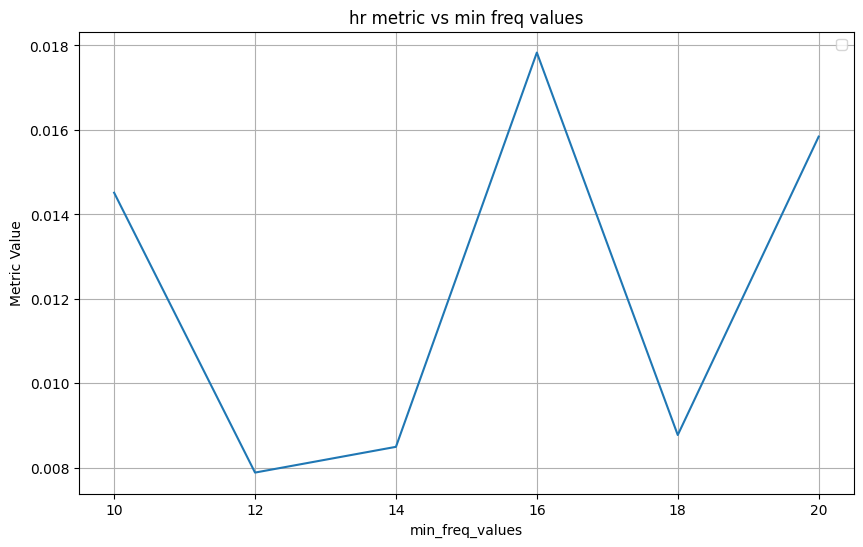

In [385]:
top_k = range(1, 100, 10)
min_freq_values = range(10, 21, 2)

plt.figure(figsize=(10, 6))
plt.plot(min_freq_values, hr_result,)
plt.xlabel("min_freq_values")
plt.ylabel("Metric Value")
plt.title("hr metric vs min freq values")
plt.legend()
plt.grid()
plt.show()

/var/folders/c7/pltxzd0965307j_5v2_v9brh0000gn/T/ipykernel_41708/328020803.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


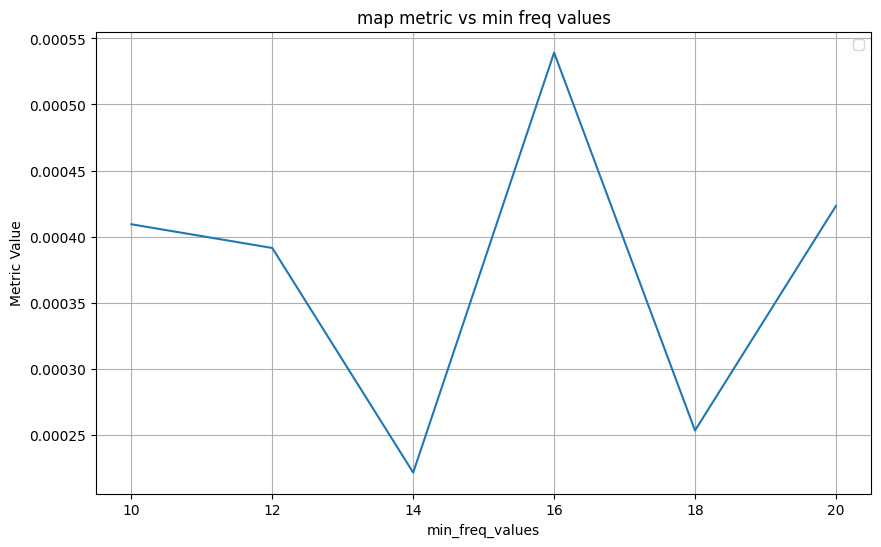

In [386]:
top_k = range(1, 100, 10)
min_freq_values = range(10, 21, 2)

plt.figure(figsize=(10, 6))
plt.plot(min_freq_values, map_result,)
plt.xlabel("min_freq_values")
plt.ylabel("Metric Value")
plt.title("map metric vs min freq values")
plt.legend()
plt.grid()
plt.show()

/var/folders/c7/pltxzd0965307j_5v2_v9brh0000gn/T/ipykernel_41708/706765406.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


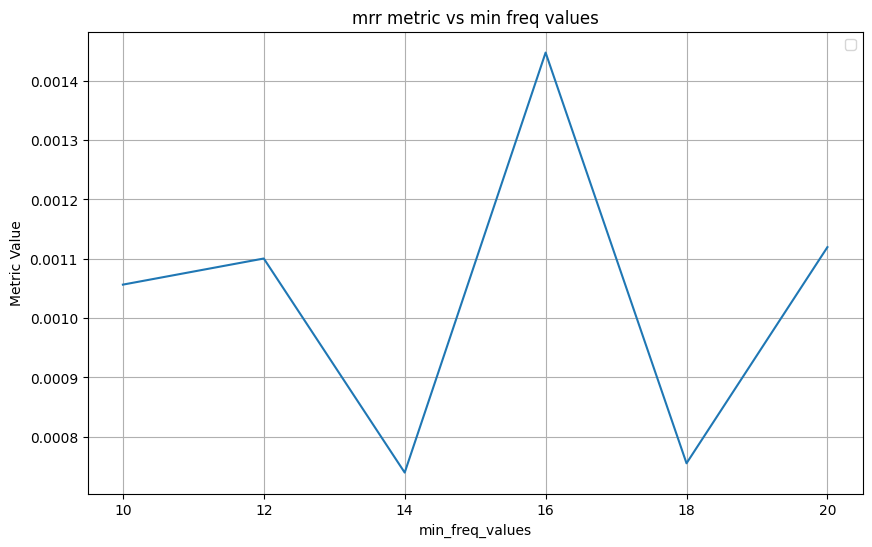

In [387]:
top_k = range(1, 100, 10)
min_freq_values = range(10, 21, 2)

plt.figure(figsize=(10, 6))
plt.plot(min_freq_values, mrr_result)
plt.xlabel("min_freq_values")
plt.ylabel("Metric Value")
plt.title("mrr metric vs min freq values")
plt.legend()
plt.grid()
plt.show()

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:** Нет, не соответствует ожиданиям. Какой-то сильной зависимости нет

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций.

In [451]:
np.array(list(item2id.keys()))

array([ 9506,  1659,  7107, ..., 10064, 13019, 10542], shape=(15706,))

In [404]:
w = fit_ease(matrix)

In [452]:
def get_item2item_recommendations(w, num_samples=10, top_n=5):
    """
    Generate item-to-item recommendations using EASE weight matrix.
    """
    sampled_items = np.random.choice(np.array(list(item2id.keys())), num_samples, replace=False)
    recommendations = {}

    for item in sampled_items:
        if item not in item2id:
            continue  # Пропускаем, если айтема нет в словаре

        item_idx = item2id[item]
        item_weights = w[item_idx]

        # Получаем топ-N рекомендаций, исключая сам айтем
        top_items = np.argsort(-item_weights).tolist()
        top_items = [int(idx) for idx in top_items if idx != item_idx and idx in id2item][:top_n]

        if len(top_items) == 0:
            continue  # Пропускаем, если не осталось рекомендаций

        # Получаем название исходного фильма
        movie_title = items.loc[items['item_id'] == item, 'title']
        if movie_title.empty:
            continue  # Пропускаем, если фильм не найден
        movie_title = movie_title.iloc[0]

        # Получаем названия рекомендованных фильмов
        recommended_titles = []
        for rec in top_items:
            rec_item_id = id2item[rec]
            rec_title = items.loc[items['item_id'] == rec_item_id, 'title']
            if not rec_title.empty:
                recommended_titles.append(rec_title.iloc[0])

        recommendations[movie_title] = recommended_titles

    return recommendations


In [453]:
get_item2item_recommendations(w, filtered_train)

ValueError: the 'dtype' parameter is not supported in the pandas implementation of prod()

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**